# Deep Learning Bootcamp: Neural Collaborative Filtering 

In this notebook, we demonstrate a basic implementation of a Collaborative Filtering model using PyTorch. This model aims to recommend items by learning the preferences of users based on item ratings, using the MovieLens dataset as an example.

Collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences from many users (collaborating). The underlying assumption is that if user A has the same opinion as user B on an issue, A is more likely to have B's opinion on a different issue.

## Setting Up the Environment
Let's set up our environment by importing the necessary libraries and checking for GPU availability. If a GPU is not available, the training process will default to the CPU.

> conda create --name jads_bootcamp python=3.11
> 
> conda activate jads_bootcamp
>
> pip install -r requirements.txt

Follow the instruction in [Installing PyTorch](https://pytorch.org/get-started/locally/) to install Pytorch in the most appropriate way for your PC configuration.

Navigate to the directory containing the .ipynb file and run:
> jupyter notebook

In [1]:
# Import necessary libraries
import os
import random
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib.ticker import FuncFormatter
from sklearn import metrics, model_selection, preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Setting device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Reproducibility
Achieving reproducible results is essential. To ensure our model produces consistent outcomes across different runs, we fix the random seed across all libraries that generate random numbers.

In [2]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)
    
    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Numpy RNG
    np.random.seed(seed)
    
    # OS RNG
    os.environ['PYTHONHASHSEED'] = str(seed)

def worker_init_fn(worker_id):    
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)

random_seed = 60
random_seed = 20
set_seed(random_seed)  

## Data Loading

Let's load the MovieLens dataset, explore it briefly, merge relevant columns, and prepare it for training.

In [3]:
# Load dataset
ratings_df = pd.read_csv("./data/ratings.csv")
print("\n\n********\nRatings Dataframe:")
print(ratings_df.head())

print("\n\n********\nTitles Dataframe:")
titles_df = pd.read_csv('./data/movies.csv')
print(titles_df.head())

# Merge the DataFrames on the movieId column
df = pd.merge(ratings_df, titles_df, on='movieId')

# Remove the 'genres' and 'timestamp' columns
df.drop(['genres', 'timestamp'], axis=1, inplace=True)

print("\n\n********\nMerged Dataframe:")
print(df.head())



********
Ratings Dataframe:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


********
Titles Dataframe:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


********
Merged Dataframe:
   userId  movieId  rating                        title
0       1        1     4.0       

### Dataset Overview

Let's take a quick look at the dataset to understand its structure and the data it contains.



Unique users: 610
Unique movies: 9724


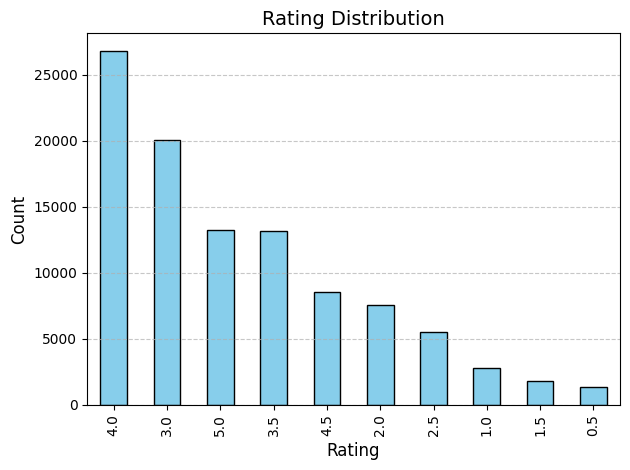

In [4]:
# Display unique user and movie counts
print(f"\nUnique users: {df.userId.nunique()}")
print(f"Unique movies: {df.movieId.nunique()}")

# Display distribution of ratings
ax = df.rating.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Rating Distribution', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Dataset Preparation

Let's preprocess the dataset, encode user and movie IDs, and split the dataset into training and validation sets.

In [5]:
# Hyperparameters
batch_size = 128

# Preprocessing for user and movie IDs in order to have all Ids from 0 to max_value
user_id_encoder = preprocessing.LabelEncoder()
movie_id_encoder = preprocessing.LabelEncoder()
df['userId'] = user_id_encoder.fit_transform(df['userId'].values)
df['movieId'] = movie_id_encoder.fit_transform(df['movieId'].values)

# Split the dataset into training and validation sets 
# The stratify parameter ensures that the distribution of the target variable, in this case, 'rating', is preserved in the train and validation datasets.
train_df, valid_df = model_selection.train_test_split(df, test_size=0.1, random_state=random_seed, stratify=df['rating'].values)

<span style="font-size:smaller;">

#### Code Breakdown

```python
user_id_encoder = preprocessing.LabelEncoder()
movie_id_encoder = preprocessing.LabelEncoder()
```

- **ID Encoding:** Label encoding transforms the user and movie IDs to a continuous range. This preprocessing step is crucial for embedding layers, which require numeric indices.

```python
train_df, valid_df = model_selection.train_test_split(...)
```

- **Training and Validation Split:** The dataset is divided into training and validation subsets, with stratification to maintain the distribution of ratings. 


```python
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
```
</span>

### PyTorch Custom Dataset

Deep learning in PyTorch uses Dataset classes that manage data loading. We define a custom class for our movie ratings data, encapsulating the logic for accessing user IDs, movie IDs, and ratings. 

In [6]:
# Custom dataset class
class MovieDataset(Dataset):
    """Movie Dataset for loading user, movie, and ratings data, keeping titles separate."""
    def __init__(self, users, movies, ratings, titles=None):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.titles = titles

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        data = {
            "users": torch.tensor(self.users[idx], dtype=torch.long),
            "movies": torch.tensor(self.movies[idx], dtype=torch.long),
            "ratings": torch.tensor(self.ratings[idx], dtype=torch.long),
        }
        if self.titles is not None:
            data["titles"] = self.titles[idx]  # Keep titles as plain Python data
        return data
        
# Create instances of the Dataset for training and validation
train_dataset = MovieDataset(users=train_df['userId'].values, movies=train_df['movieId'].values, ratings=train_df['rating'].values, titles=train_df['title'].values)
valid_dataset = MovieDataset(users=valid_df['userId'].values, movies=valid_df['movieId'].values, ratings=valid_df['rating'].values, titles=valid_df['title'].values)

# DataLoader instances for batching with more descriptive names
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

<span style="font-size:smaller;">

#### Code Breakdown

```python
class MovieDataset(Dataset):
    def __init__(self, users, movies, ratings, titles=None):
        ...
```

- MovieDataset class is designed to handle datasets comprising user IDs, movie IDs, ratings, and optionally, movie titles. It inherits from PyTorch's `Dataset` class, making it compatible with PyTorch's data loading and batching mechanisms.

```python
def __len__(self):
    return len(self.users)
```

- **Dataset Length:** The `__len__` method returns the total number of ratings in the dataset, providing PyTorch's `DataLoader` with the size of the dataset.

```python
def __getitem__(self, idx):
    ...
```

- **Data Retrieval:** The `__getitem__` method constructs a dictionary for a given index `idx`, mapping "users", "movies", and "ratings" to their respective tensor values. If titles are provided, they're included as raw Python data, not as tensors, since they might be used for interpretability rather than computation.

```python
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
```

- **Batching and Shuffling:** `DataLoader` instances for training and validation datasets facilitate the batching of data. Shuffling the training data helps improve model generalization by reducing order bias.

</span>

### Let's check our data

In [7]:
# Fetch a single batch of data
databatch_iter = iter(train_loader)
databatch = next(databatch_iter)

# Print user IDs from the batch and their size
print("\nShape of User IDs batch:", databatch['users'].size())
print("User IDs from the batch:")
print(databatch['users'])

# Print movie IDs from the batch and their size
print("\nShape of Movie IDs batch:", databatch['movies'].size())
print("Movie IDs from the batch:")
print(databatch['movies'])

# Print movie titles from the batch and their size
print("\nLen of Movie Titles batch:", len(databatch['titles']))
print("Movie of the first 10 titles from the batch:")
print(databatch['titles'][:10])


Shape of User IDs batch: torch.Size([128])
User IDs from the batch:
tensor([369, 291, 598, 306,  28, 248, 492, 451, 409, 248,  21, 158, 287, 198,
        461, 599, 562, 287,  56, 413, 609, 599, 599, 473,  78, 273, 364, 201,
        124, 589,  58, 165, 116, 598, 513, 347, 473, 409, 563, 473,  61,  88,
        231, 607, 447, 231, 599, 351,  20,  19, 353, 124, 199, 572, 516, 489,
         83,  81, 104,   4, 358, 412, 558, 297, 317, 303, 413, 237, 479, 239,
        516, 609, 221, 468, 379, 413, 221, 444, 110,  80, 524, 566, 134, 376,
        598, 606, 379,  21,  63, 144, 447, 287, 181,  65, 488, 419,  20,  50,
        138, 190, 496, 222,  67, 110,  67, 571, 386, 165, 338,  49, 383,  22,
        427,  90, 118, 413, 413, 591, 592, 476, 220, 288, 473, 110,  10, 291,
        312, 427])

Shape of Movie IDs batch: torch.Size([128])
Movie IDs from the batch:
tensor([1939, 1180, 1857, 4354, 1083, 9574,   97, 1370, 1607, 7823, 1615,   30,
        4786, 1627, 5009, 2109, 5892, 3343, 1945,  921, 657

### Model Architecture

We define a simple neural network model for our collaborative filtering task. The model uses embedding layers to learn representations for users and movies. The model predicts a rating given a user and a movie by combining these embeddings and processing them through additional layers

In [8]:
# Define the collaborative filtering model
class CollaborativeFilteringModel(nn.Module):
    """A model for collaborative filtering based recommendations."""
    def __init__(self, num_users, num_movies, embedding_size=32, dropout_rate=0.5):
        super(CollaborativeFilteringModel, self).__init__()
        
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(embedding_size * 2, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  
            nn.Linear(8, 1)
        )
        
    def forward(self, users, movies):
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        output = self.linear_relu_stack(combined)
        
        return output

<span style="font-size:smaller;">

#### Code Breakdown

```python
class CollaborativeFilteringModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=32, dropout_rate=0.5):
        ...
```

- CollaborativeFilteringModel predicts user ratings for movies based on learned embeddings for both entities. 

- **Embeddings:** The model initializes embeddings for both users and movies, transforming sparse user and movie IDs into dense vectors of a specified `embedding_size`. These embeddings capture latent factors associated with users' preferences and movies' characteristics.

```python
self.linear_relu_stack = nn.Sequential(...)
```

- **Neural Network Architecture:** After combining user and movie embeddings, the model processes them through a sequence of linear layers and ReLU activations, interspersed with dropout layers to mitigate overfitting. The network has a single output, representing the predicted rating.

```python
def forward(self, users, movies):
    ...
    return output
```

- **Processing Flow:** In the `forward` method, user and movie IDs are first passed through their respective embedding layers. The resulting vectors are concatenated and then fed into the neural network, outputting a predicted rating.

- **Combining Embeddings:** Concatenating user and movie embeddings allows the model to learn from the interaction between these two sets of latent factors, which is central to collaborative filtering.

##### Practical Considerations

- **Embedding Size:** This hyperparameter controls the dimensionality of the latent space. While larger embeddings can capture more nuanced factors, they also require more data to train effectively and can lead to overfitting.

</span>

### Let's initialize the model

In [9]:
# Initialize the model
num_users = len(user_id_encoder.classes_)
num_movies = len(movie_id_encoder.classes_)
model = CollaborativeFilteringModel(num_users=num_users, num_movies=num_movies).to(device)

### Let's check our expected output

In [10]:
# Let's use the model's embeddings directly to get the embeddings for users and movies in the batch
user_embeddings = model.user_embedding(databatch['users'].to(device))
movie_embeddings = model.movie_embedding(databatch['movies'].to(device))

# Print out the embeddings 
print("\nFirst User Embedding:")
print(user_embeddings[0])
print("Shape of User Embeddings:", user_embeddings.size())

print("\nFirst Movie Embedding:")
print(movie_embeddings[0])
print("Shape of Movie Embeddings:", movie_embeddings.size())

# Print out the model's output
with torch.no_grad():
    model_output = model(databatch['users'].to(device), databatch["movies"].to(device))

    print(f"\nModel_output size: {model_output.size()}")
    print(f"GT Ratings size: {databatch['ratings'].size()}")

    print(f"\nModel_output first 5 elements: {model_output[:5].view(-1)}")
    print(f"GT Ratings first 5 elements: {databatch['ratings'][:5]}")


First User Embedding:
tensor([ 0.3147,  1.5598,  0.5476, -0.0684,  0.6883,  0.3082,  1.7377, -1.0355,
         1.8372,  0.2292,  2.2693,  0.8202,  1.4117,  1.5194,  1.4949,  0.3514,
         0.5281,  1.6022, -0.0947, -0.3328, -2.7073, -0.1223,  0.7323,  0.0551,
         0.7965,  0.7851, -2.3919, -0.3935, -0.1707,  1.5907,  1.4197,  0.8221],
       device='cuda:0', grad_fn=<SelectBackward0>)
Shape of User Embeddings: torch.Size([128, 32])

First Movie Embedding:
tensor([-5.5847e-01, -1.5810e+00,  1.4555e+00, -1.8653e-02,  5.9419e-01,
         1.0978e+00, -6.7983e-01,  4.1261e-01, -3.7289e-01,  5.6055e-02,
         5.1682e-01, -7.6982e-01,  5.4623e-01, -1.2269e+00,  9.9755e-01,
         6.7615e-01,  7.0752e-01, -3.9171e-01,  1.8334e+00,  4.2595e-01,
         7.5570e-04, -1.0983e-01,  9.0654e-01,  4.1829e-01, -1.5780e+00,
         9.7510e-01,  8.1976e-01, -4.8681e-03,  1.0163e-01, -1.0666e+00,
        -2.0952e+00,  7.8016e-01], device='cuda:0', grad_fn=<SelectBackward0>)
Shape of Movie E

### Initialize optimizer, and loss function

In [11]:
# Initialize optimizer, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

### Training Loop

Now, let's train our model using the training dataset.

In [12]:
# Training and validation loop with loss tracking
num_epochs = 25
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    total_valid_loss = 0
    
    # Training
    for batch_idx, batch in enumerate(train_loader):
        users, movies, ratings = batch['users'].to(device), batch['movies'].to(device), batch['ratings'].to(device)
        
        predictions = model(users, movies).squeeze()

        ratings = batch["ratings"].to(torch.float32).to(device)
        
        loss = loss_fn(predictions, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in valid_loader:
            users, movies, ratings = batch['users'].to(device), batch['movies'].to(device), batch['ratings'].to(device)
            predictions = model(users, movies).squeeze()
            loss = loss_fn(predictions, ratings)
            total_valid_loss += loss.item()
            
    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

Epoch 1/25, Train Loss: 4.2364, Validation Loss: 1.4253
Epoch 2/25, Train Loss: 2.5711, Validation Loss: 1.2755
Epoch 3/25, Train Loss: 2.0566, Validation Loss: 1.1683
Epoch 4/25, Train Loss: 1.7394, Validation Loss: 1.0948
Epoch 5/25, Train Loss: 1.4880, Validation Loss: 1.0386
Epoch 6/25, Train Loss: 1.2999, Validation Loss: 1.0031
Epoch 7/25, Train Loss: 1.1589, Validation Loss: 0.9768
Epoch 8/25, Train Loss: 1.0625, Validation Loss: 0.9546
Epoch 9/25, Train Loss: 1.0012, Validation Loss: 0.9366
Epoch 10/25, Train Loss: 0.9678, Validation Loss: 0.9224
Epoch 11/25, Train Loss: 0.9476, Validation Loss: 0.9129
Epoch 12/25, Train Loss: 0.9360, Validation Loss: 0.9099
Epoch 13/25, Train Loss: 0.9279, Validation Loss: 0.9009
Epoch 14/25, Train Loss: 0.9199, Validation Loss: 0.8952
Epoch 15/25, Train Loss: 0.9179, Validation Loss: 0.9022
Epoch 16/25, Train Loss: 0.9114, Validation Loss: 0.8961
Epoch 17/25, Train Loss: 0.9103, Validation Loss: 0.9027
Epoch 18/25, Train Loss: 0.9115, Validat

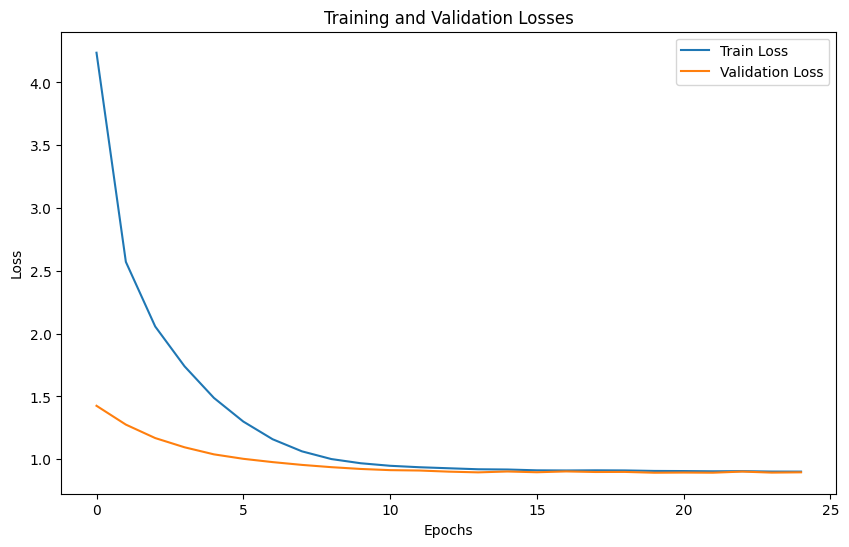

In [13]:
# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

### Evaluating the Model

After training, it's important to evaluate our model on the validation set to understand its performance.

#### RMSE 

In [14]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_rmse = 0
    total_count = 0
    with torch.no_grad():
        for batch in data_loader:
            users, movies, ratings = batch['users'].to(device), batch['movies'].to(device), batch['ratings'].to(device)
            predictions = model(users, movies).squeeze()
            loss = torch.sqrt(((predictions - ratings) ** 2).mean()).item()  # Calculate RMSE for the batch
            total_rmse += loss * len(users)
            total_count += len(users)
    avg_rmse = total_rmse / total_count
    print(f"Average RMSE: {avg_rmse:.4f}")

# Evaluate the model on the validation set
evaluate_model(model, valid_loader)

Average RMSE: 0.9437


Let's calculate model prediction for a set of inputs:

In [15]:
# Fetch a single batch of data
databatch_iter = iter(train_loader)
databatch = next(databatch_iter)

# Print out the model's output
with torch.no_grad():
    model_output = model(databatch['users'].to(device), databatch["movies"].to(device))

model_output_formatted = model_output[:8].view(-1).cpu().numpy()
gt_ratings_formatted = databatch['ratings'][:8].cpu().numpy()

# Print the aligned vectors together
print(f"{'Model_output':<28}GT Ratings:")
for i in range(5):
    print(f"{model_output_formatted[i]:<28.2f} {gt_ratings_formatted[i]}")

Model_output                GT Ratings:
3.52                         4
2.87                         0
3.41                         4
3.25                         3
3.56                         4


### Embeddings Visualization
We can create a visualizations to show how various movies are encoded in embeddings space. 
Let's apply the Principal Components Analysis to reduce the dimentionality of embeddings and show the 1st component.

In [16]:
# Extract movie embeddings from the model
movie_embeddings_array = model.movie_embedding.weight.data.cpu().numpy()

# Create a dictionary mapping movie IDs to titles
movie_id_to_title = {row['movieId']: row['title'] for index, row in df.iterrows()}

# Create a DataFrame for movie embeddings with original movie IDs
movie_embeddings_df = pd.DataFrame(movie_embeddings_array)
movie_embeddings_df['encoded_movie_id'] = movie_embeddings_df.index
movie_embeddings_df['movie_id'] = movie_embeddings_df['encoded_movie_id'].astype(df['movieId'].dtype)
movie_embeddings_df['title'] = movie_embeddings_df['movie_id'].map(movie_id_to_title)
movie_embeddings_df.drop('encoded_movie_id', axis=1, inplace=True)

# Print the first few rows of the resulting DataFrame
print(movie_embeddings_df.head())

          0         1         2         3         4         5         6  \
0  1.231425 -0.213810 -0.026144 -0.816446  1.879727  1.107180  0.844645   
1 -0.838589 -0.058263 -0.084299  0.217535 -0.755930  0.508807  0.716972   
2 -0.591758 -0.881141  0.120969 -0.407564 -0.118269 -0.011364  0.303076   
3  0.013265  0.042704 -0.000040  0.017658 -0.129858 -0.003177 -0.276591   
4 -0.547894 -0.348831 -0.043492  0.143396  0.322098  0.039361  0.729851   

          7         8         9  ...        24        25        26        27  \
0  1.078324  0.209958  0.063424  ...  0.051130 -0.248009  0.398942  0.789560   
1 -0.551895 -0.323010  0.504303  ...  0.674549  0.169644  1.189827 -0.118003   
2 -0.257343 -0.752551 -0.912580  ... -0.484164 -0.051217  0.890483 -0.051866   
3  0.116627  0.142661  0.030400  ...  0.036602 -0.039879 -0.128795  0.067187   
4  0.219585  0.486426  0.000415  ... -0.027450  0.390400 -0.620690 -0.343071   

         28        29        30        31  movie_id  \
0 -1.388395 -

In [17]:
# Perform PCA to reduce embeddings to 5 components
pca = PCA(n_components=5)
pca_result = pca.fit_transform(movie_embeddings_array)

# Add PCA components to a new DataFrame
df_movies_pca = movie_embeddings_df.copy()
pca_columns = [f'pca_component_{i+1}' for i in range(5)]
for i, column_name in enumerate(pca_columns):
    df_movies_pca[column_name] = pca_result[:, i]

df_movies_pca = df_movies_pca[['movie_id', 'title'] + pca_columns]
df_movies_pca.head()

,movie_id,title,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5
0,0,Toy Story (1995),-0.412980,1.650178,-0.877032,-1.015260,1.869164
1,1,Jumanji (1995),-0.021712,-1.008685,1.294908,0.479002,-0.139842
2,2,Grumpier Old Men (1995),0.072146,1.019276,1.021231,0.063280,0.232505
3,3,Waiting to Exhale (1995),0.710256,0.202832,-0.098426,0.063731,-0.101839
4,4,Father of the Bride Part II (1995),0.341167,-0.794840,0.383008,-0.892542,-0.264470


In [22]:
def plot_components(components_df, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 6))
    
    # Sort and select top movies based on the specified component
    subset = components_df.sort_values(by=component, ascending=ascending).head()
    
    # Titles for the selected movies
    titles = ['\n'.join(wrap(t, width=14)) for t in subset['title']]
    
    # Plotting
    ax.bar(range(len(titles)), subset[component], color='skyblue', edgecolor='black')
    
    ax.set_xticks(range(len(titles)))
    ax.set_xticklabels(titles, fontsize=12)
    
    # Use FuncFormatter to format y-tick labels
    formatter = FuncFormatter(lambda y, _: f'{y:2.2f}')
    ax.yaxis.set_major_formatter(formatter)
    
    plot_title = f"Movies with {'highest' if not ascending else 'lowest'} '{component}' component values"
    ax.set_title(plot_title, fontsize=20)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

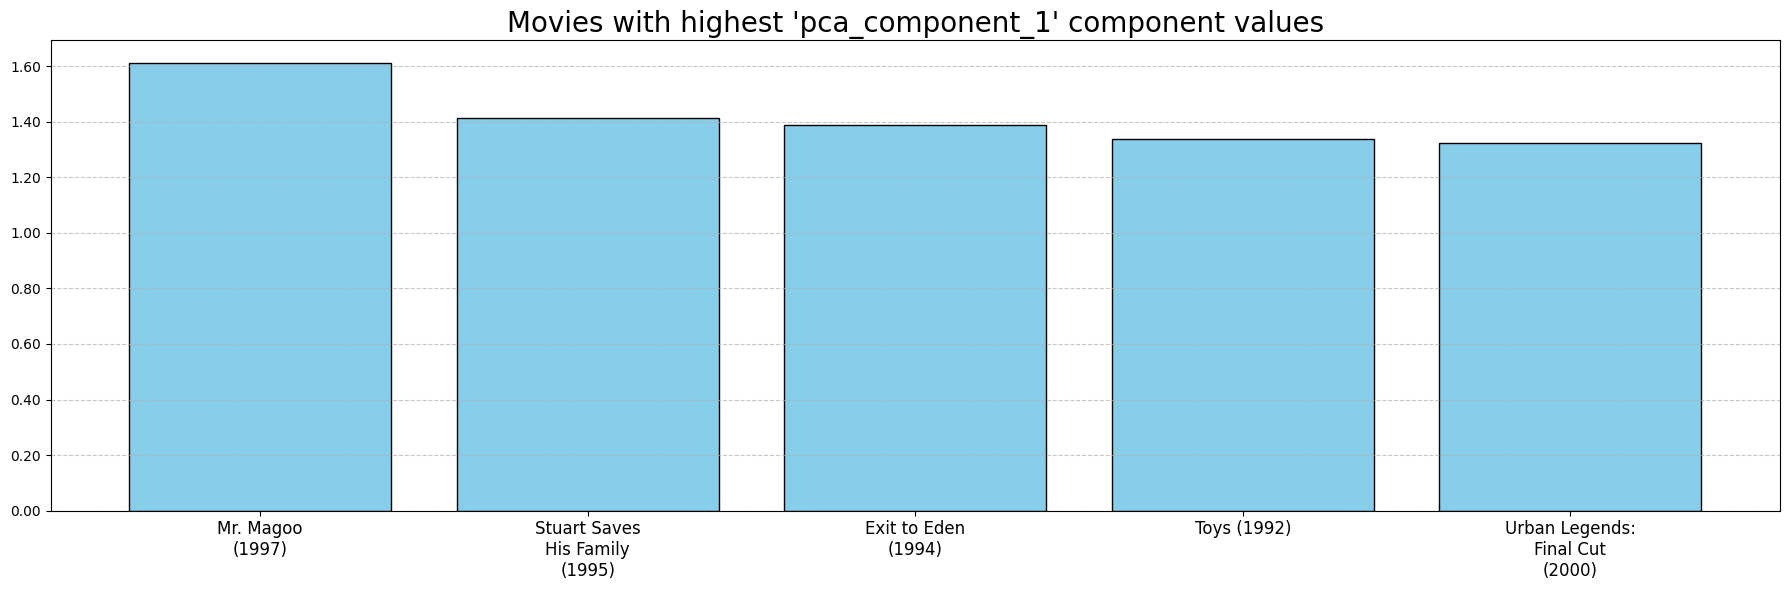

In [23]:
plot_components(df_movies_pca, 'pca_component_1', ascending=False)

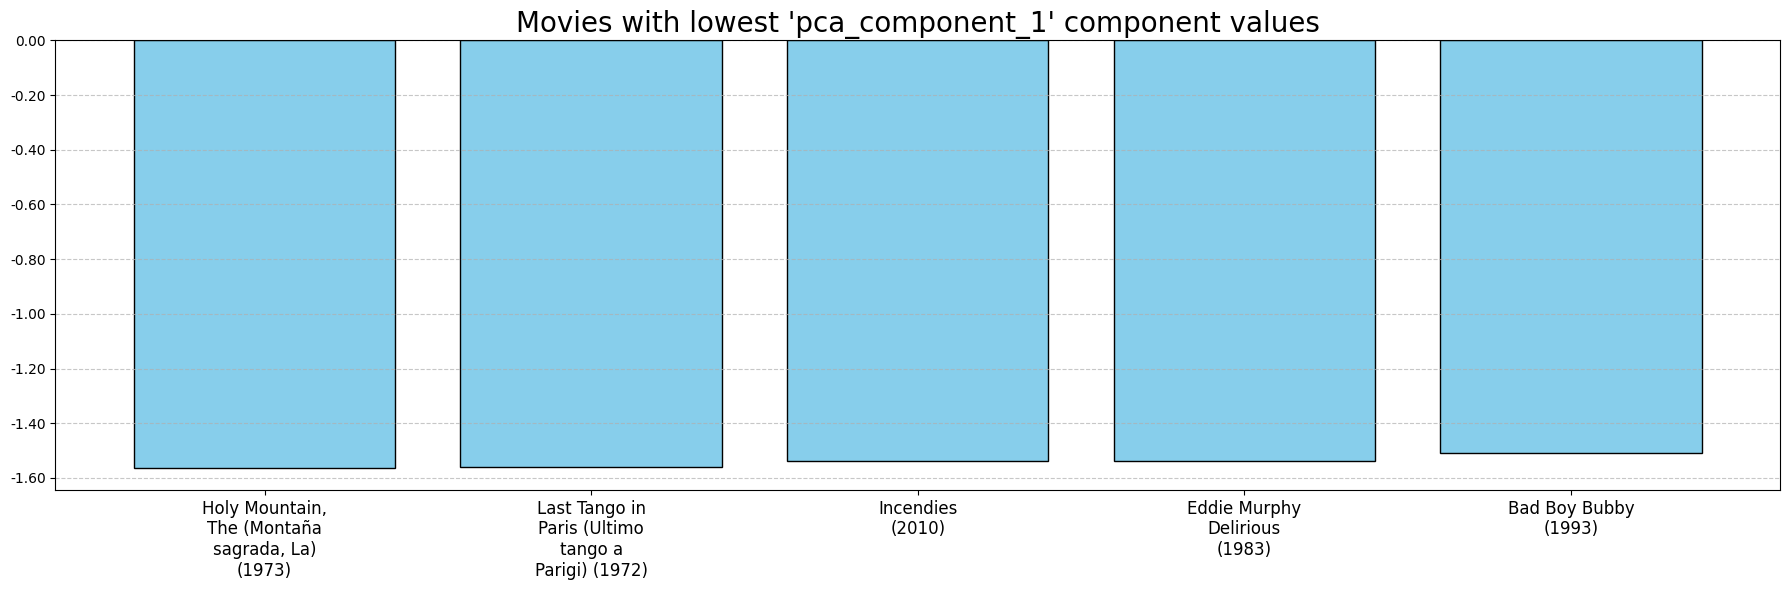

In [24]:
plot_components(df_movies_pca, 'pca_component_1', ascending=True)